# Displayport-size-tuning experiment, bug 1251052

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client, get_clients_history

%pylab inline

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


Let's fetch Telemetry submissions for the build-ids around the experiment period...

In [2]:
pings = get_pings(sc, app="Firefox", channel="nightly", build_id=("20160301000000", "20160318999999"), fraction=1.0)

... and extract only the attributes we need from the Telemetry submissions:

In [3]:
subset = get_pings_properties(pings, ["environment/addons/activeExperiment",
                                      "environment/system/os/name",
                                      "payload/histograms/CHECKERBOARD_SEVERITY",
                                      "payload/histograms/CHECKERBOARD_DURATION",
                                      "payload/histograms/CHECKERBOARD_POTENTIAL_DURATION",
                                      "payload/histograms/CHECKERBOARD_PEAK"])

Let's filter out submissions that aren't in the experiment:

In [4]:
subset = subset.filter(lambda p: p.get("environment/addons/activeExperiment") is not None)
subset = subset.filter(lambda p: "id" in p.get("environment/addons/activeExperiment"))
subset = subset.filter(lambda p: p.get("environment/addons/activeExperiment")["id"] == u'displayport-tuning-nightly@experiments.mozilla.org')

Some of the submissions don't have a branch attribute, and are invalid. Discard those:

In [5]:
valid = subset.filter(lambda p: "branch" in p.get("environment/addons/activeExperiment"))
valid = valid.cache()

(For debugging) Inspect a random one just to make sure it looks sane:

In [6]:
# valid.take(1)

How many pings are we looking at?

In [7]:
valid.count()

217648

### OS breakdown

Let's look at the OS breakdown to make sure that Windows is dominating - that way we know the sample is representative of our release population

In [8]:
os_mac = valid.filter(lambda p: p["environment/system/os/name"] == "Darwin")
os_win = valid.filter(lambda p: p["environment/system/os/name"] == "Windows_NT")
os_nix = valid.filter(lambda p: p["environment/system/os/name"] == "Linux")

In [9]:
[os_mac.count(), os_win.count(), os_nix.count()]

[4628, 209075, 3945]

Yup, Windows is winning here.

### Build probe histogram data

Let's split out the different histograms and group them by the experiment branch:

In [10]:
hist_duration = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_DURATION"])).groupByKey().collectAsMap()
hist_peak = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_PEAK"])).groupByKey().collectAsMap()
hist_potential_duration = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_POTENTIAL_DURATION"])).groupByKey().collectAsMap()
hist_severity = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_SEVERITY"])).groupByKey().collectAsMap()

(Sanity check) Make sure we have a bunch of samples, and comparable numbers in each branch:

In [11]:
{x: len(list(y)) for x, y in hist_duration.items()}

{u'control': 34267,
 u'group2': 36644,
 u'group3': 36529,
 u'group4': 37369,
 u'group5': 36625,
 u'group6': 36214}

Aggregate the histograms over all submissions, for each branch of the experiment:

In [12]:
def aggregate_arrays(xs, ys):
    if xs is None:
        return ys
    
    if ys is None:
        return xs
    
    return xs + ys


aggr_duration = {x: reduce(aggregate_arrays, y) for x, y in hist_duration.items()}
aggr_peak = {x: reduce(aggregate_arrays, y) for x, y in hist_peak.items()}
aggr_potential_duration = {x: reduce(aggregate_arrays, y) for x, y in hist_potential_duration.items()}
aggr_severity = {x: reduce(aggregate_arrays, y) for x, y in hist_severity.items()}

### Total checkerboard events

Each checkerboard event creates one data point for the duration/peak/severity probes, so we sum up the number of data points in the duration probe to get the number of checkerboard events that were recorded. We would get the same numbers if we used peak or severity.

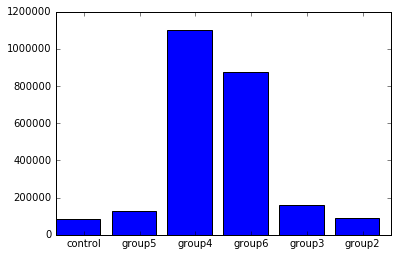

In [13]:
labels = [x for x, y in aggr_duration.items()]
counts = [sum(y) for x, y in aggr_duration.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

### Histograms

Let's plot the different probes. Each probe is plotted onto a single graph with different colored lines for the different branches in the experiment. Let's start with duration:

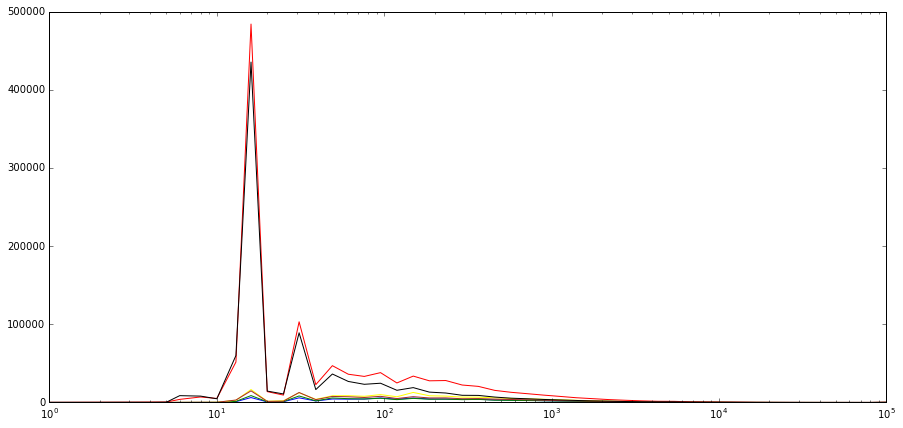

In [14]:
aggr_duration["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_duration["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_duration["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_duration["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_duration["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_duration["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

Two of the groups there are clearly dominating. Let's comment those out to get a closer look at the remaining 4:

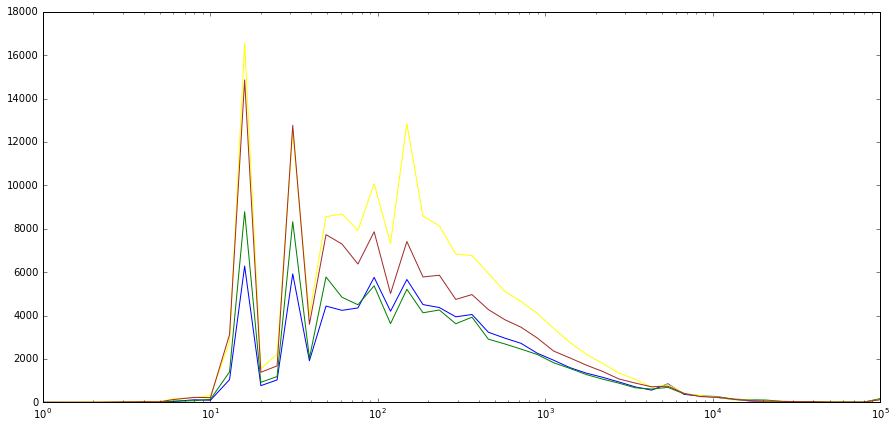

In [15]:
aggr_duration["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_duration["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_duration["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
# aggr_duration["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_duration["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
# aggr_duration["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

Let's do the same for the peak checkerboard values:

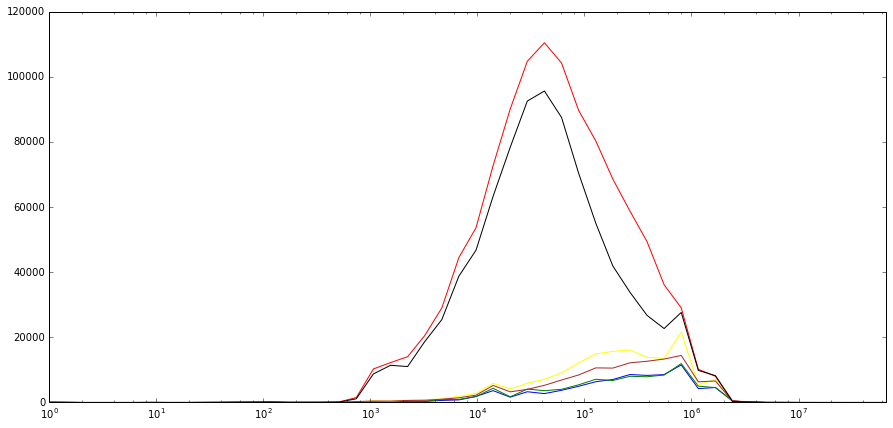

In [16]:
aggr_peak["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_peak["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_peak["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_peak["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_peak["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_peak["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

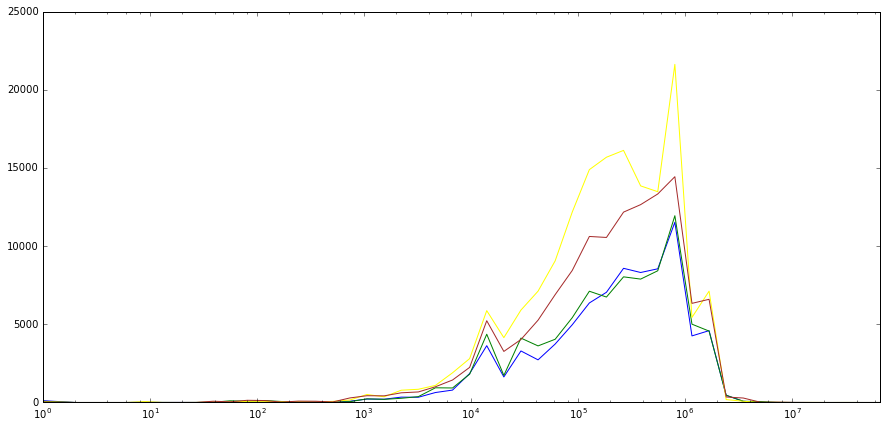

In [17]:
aggr_peak["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_peak["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_peak["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
# aggr_peak["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_peak["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
# aggr_peak["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

Also for potential duration. These we expect to be pretty much equal across all branches of the experiment, because it is more a measure of browsing behaviour than of checkerboarding.

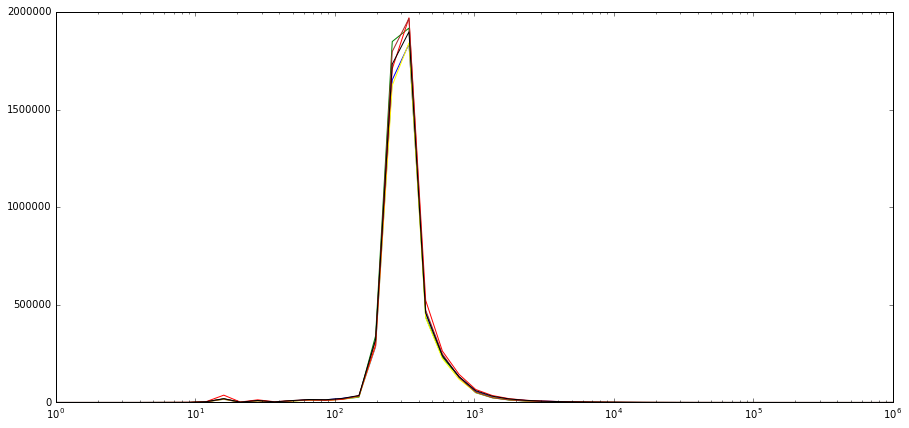

In [18]:
aggr_potential_duration["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_potential_duration["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_potential_duration["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_potential_duration["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_potential_duration["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_potential_duration["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

And finally, the severities:

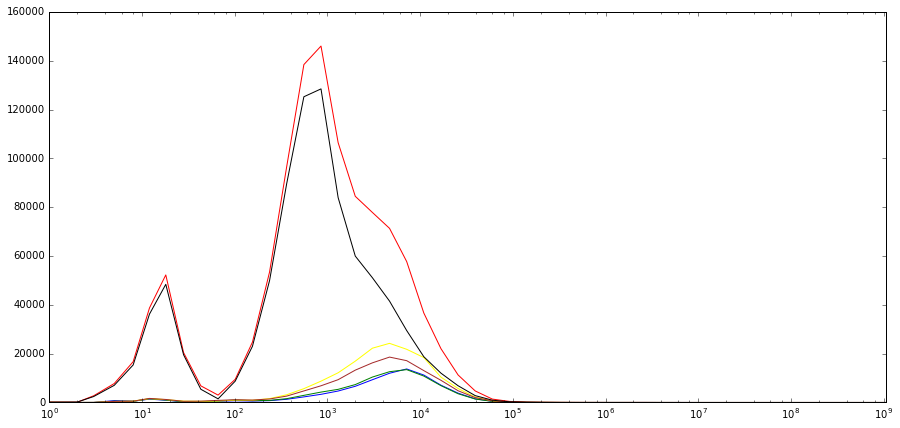

In [19]:
aggr_severity["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_severity["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_severity["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_severity["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_severity["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_severity["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

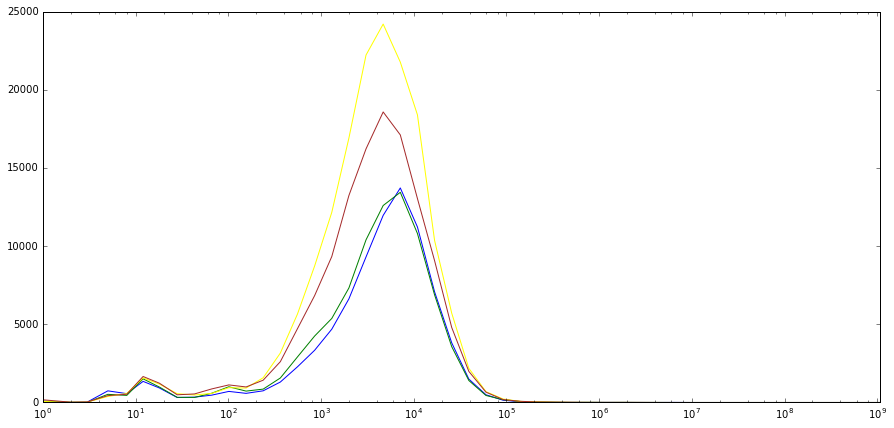

In [20]:
aggr_severity["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_severity["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_severity["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
# aggr_severity["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_severity["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
# aggr_severity["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

### Sample sums (net badness)

The above histograms show us the distribution of the probes in the different branches. However it may be that a small number of large-valued samples is worse than a large number of small-valued samples. Below we take the sample sum for each probe, so that instead of a distribution graph we have a single value to compare the "badness" of the probe for each branch of the experiment.

In [21]:
def sample_sum(series):
    total = 0
    for i in range(0, len(series.index)):
        total += (series.iat[i] * series.index[i])
    return total

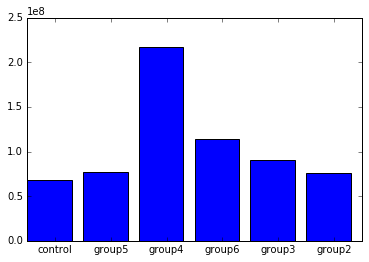

In [22]:
labels = [x for x, y in aggr_duration.items()]
counts = [sample_sum(y) for x, y in aggr_duration.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

So in the above graph, we see that the net duration is highest in group 4, and significantly lower in group 6. From the previous distribution graph it might not have been obvious that group 6 was much better. Let's do the same for the other probes. Peak:

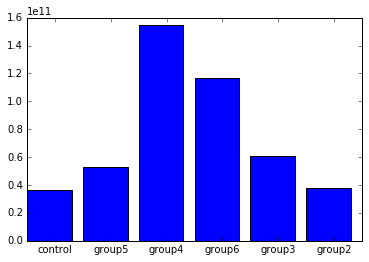

In [23]:
labels = [x for x, y in aggr_peak.items()]
counts = [sample_sum(y) for x, y in aggr_peak.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

Potential duration. Again we expect this one to be pretty much the same across all branches.

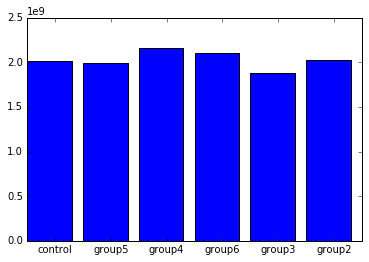

In [24]:
labels = [x for x, y in aggr_potential_duration.items()]
counts = [sample_sum(y) for x, y in aggr_potential_duration.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

And severity:

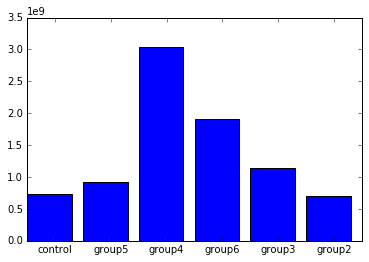

In [25]:
labels = [x for x, y in aggr_severity.items()]
counts = [sample_sum(y) for x, y in aggr_severity.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

## Ad-hoc analysis

Below are some ad-hoc/exploratory analyses to make more sense of the data and to make sure the interpretation is consistent.

### OS distribution of group 4 duration

Here we dive into the DURATION probe for group 4 (the worst one) and break it down by OS:

In [26]:
group4_samples = valid.filter(lambda p: p["environment/addons/activeExperiment"]["branch"] == "group4")
hist_group4_duration = group4_samples.map(lambda p: (p["environment/system/os/name"], p["payload/histograms/CHECKERBOARD_DURATION"])).groupByKey().collectAsMap()
aggr_group4_duration = {x: reduce(aggregate_arrays, y) for x, y in hist_group4_duration.items()}

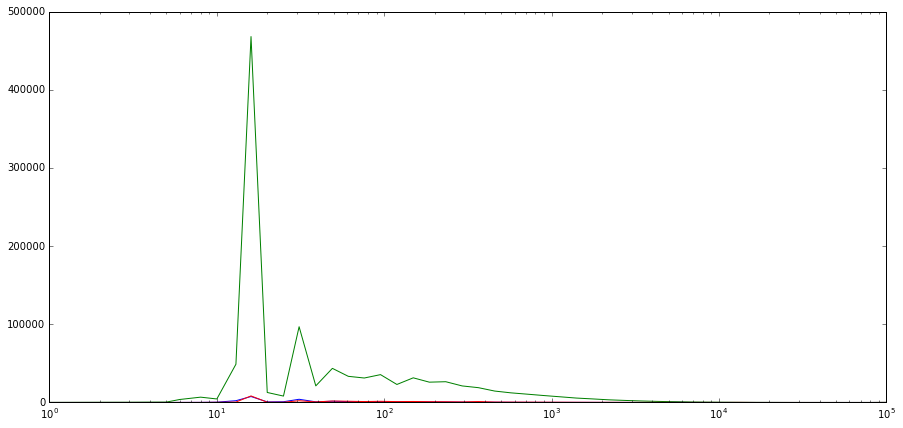

In [27]:
aggr_group4_duration["Darwin"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_group4_duration["Windows_NT"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_group4_duration["Linux"].plot(kind="line", figsize=(15, 7), logx=True, color="red")

As expected, we see Windows dominating. However this is an absolute number, and it would be more interesting to see this normalized by the number of pings submitted on the platform. That would tell us the relative duration of checkerboard events on each platform:

In [28]:
totals = {x: sum(y) for x, y in aggr_group4_duration.items()}
aggr_group4_duration_normalized = {x: y / totals[x] for x, y in aggr_group4_duration.items()}

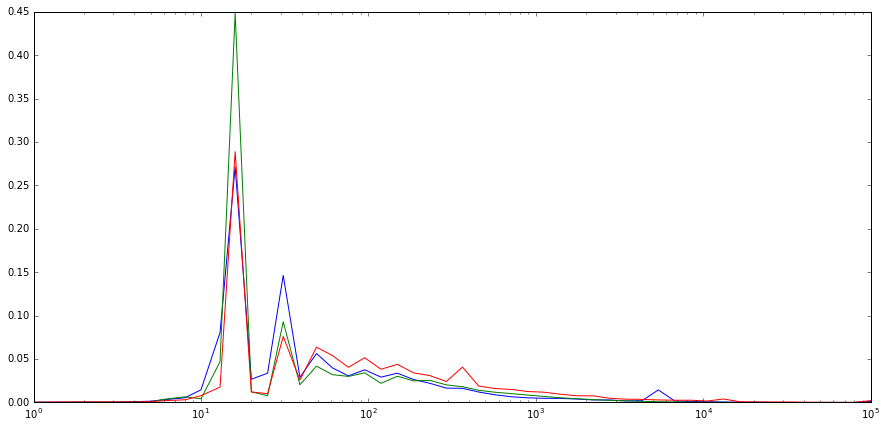

In [29]:
aggr_group4_duration_normalized["Darwin"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_group4_duration_normalized["Windows_NT"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_group4_duration_normalized["Linux"].plot(kind="line", figsize=(15, 7), logx=True, color="red")

This is interesting, we see that on Windows, proportionally, most of the checkerboard durations are very short and as you go into the middle durations Mac dominates, and at the longer durations Linux dominates.

### OS distribution of group 4 severity

Same OS breakdown, but for the SEVERITY probe:

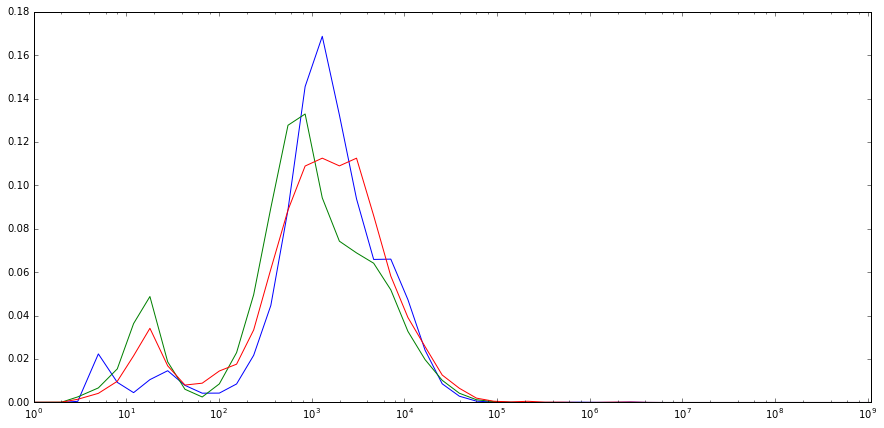

In [30]:
hist_group4_severity = group4_samples.map(lambda p: (p["environment/system/os/name"], p["payload/histograms/CHECKERBOARD_SEVERITY"])).groupByKey().collectAsMap()
aggr_group4_severity = {x: reduce(aggregate_arrays, y) for x, y in hist_group4_severity.items()}
aggr_group4_severity_normalized = {x: y / totals[x] for x, y in aggr_group4_severity.items()}
aggr_group4_severity_normalized["Darwin"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_group4_severity_normalized["Windows_NT"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_group4_severity_normalized["Linux"].plot(kind="line", figsize=(15, 7), logx=True, color="red")

### Other probes

There are other probes that might be good to analyze.

In [31]:
subset = get_pings_properties(pings, ["environment/addons/activeExperiment",
                                      "environment/system/os/name",
                                      "payload/histograms/COMPOSITE_FRAME_ROUNDTRIP_TIME",
                                      "payload/histograms/COMPOSITE_TIME",
                                      "payload/histograms/PAINT_BUILD_DISPLAYLIST_TIME",
                                      "payload/histograms/PAINT_RASTERIZE_TIME"])
subset = subset.filter(lambda p: p.get("environment/addons/activeExperiment") is not None)
subset = subset.filter(lambda p: "id" in p.get("environment/addons/activeExperiment"))
subset = subset.filter(lambda p: p.get("environment/addons/activeExperiment")["id"] == u'displayport-tuning-nightly@experiments.mozilla.org')
valid = subset.filter(lambda p: "branch" in p.get("environment/addons/activeExperiment"))
valid = valid.cache()
valid.count()

217648

In [32]:
hist_roundtrip = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/COMPOSITE_FRAME_ROUNDTRIP_TIME"])).groupByKey().collectAsMap()
hist_composite = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/COMPOSITE_TIME"])).groupByKey().collectAsMap()
hist_displaylist = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/PAINT_BUILD_DISPLAYLIST_TIME"])).groupByKey().collectAsMap()
hist_rasterize = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/PAINT_RASTERIZE_TIME"])).groupByKey().collectAsMap()
aggr_roundtrip = {x: reduce(aggregate_arrays, y) for x, y in hist_roundtrip.items()}
aggr_composite = {x: reduce(aggregate_arrays, y) for x, y in hist_composite.items()}
aggr_displaylist = {x: reduce(aggregate_arrays, y) for x, y in hist_displaylist.items()}
aggr_rasterize = {x: reduce(aggregate_arrays, y) for x, y in hist_rasterize.items()}

Composite round-trip events, count and distribution:

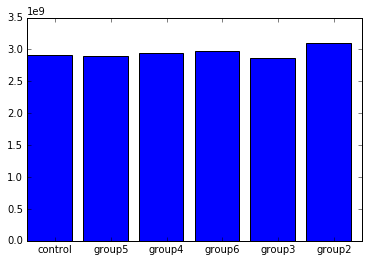

In [33]:
labels = [x for x, y in aggr_roundtrip.items()]
counts = [sum(y) for x, y in aggr_roundtrip.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

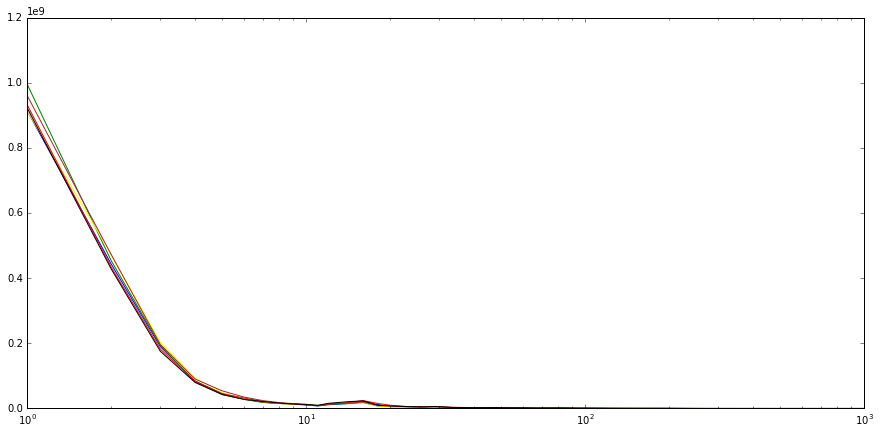

In [34]:
aggr_roundtrip["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_roundtrip["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_roundtrip["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_roundtrip["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_roundtrip["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_roundtrip["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

Composite events, count and distribution:

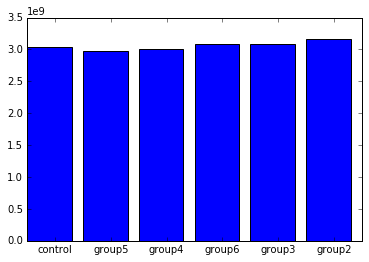

In [35]:
labels = [x for x, y in aggr_composite.items()]
counts = [sum(y) for x, y in aggr_composite.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

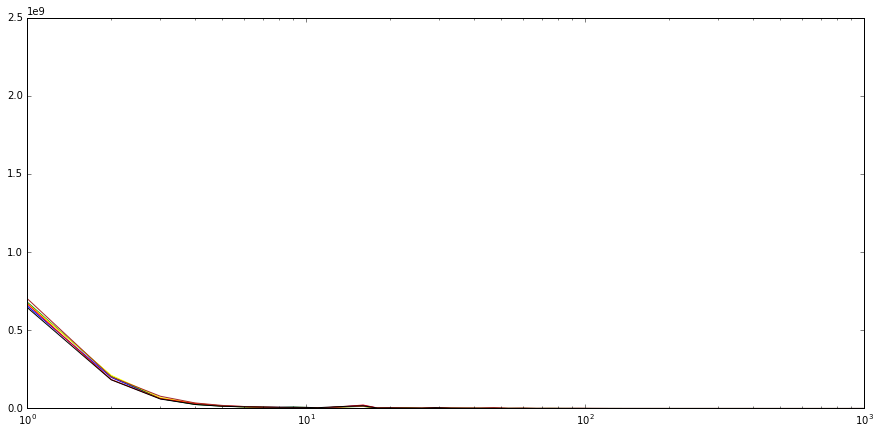

In [36]:
aggr_composite["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_composite["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_composite["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_composite["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_composite["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_composite["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

Display list build events, count and distribution:

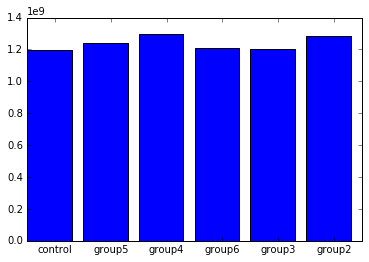

In [37]:
labels = [x for x, y in aggr_displaylist.items()]
counts = [sum(y) for x, y in aggr_displaylist.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

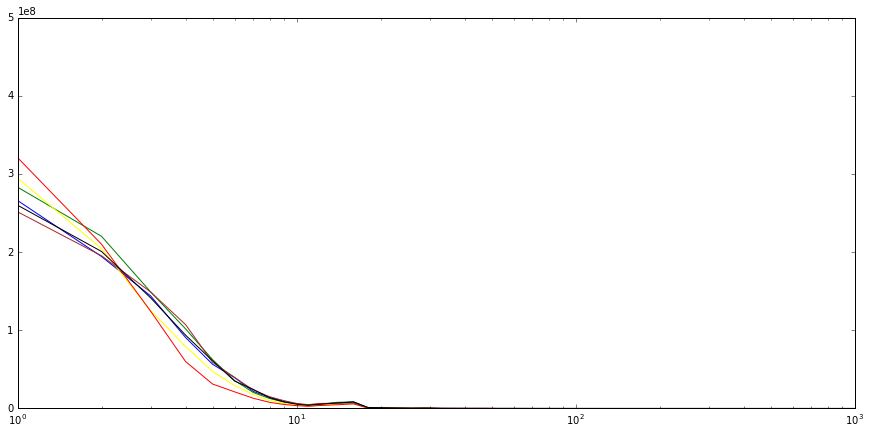

In [38]:
aggr_displaylist["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_displaylist["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_displaylist["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_displaylist["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_displaylist["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_displaylist["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

Rasterizations, count and distribution:

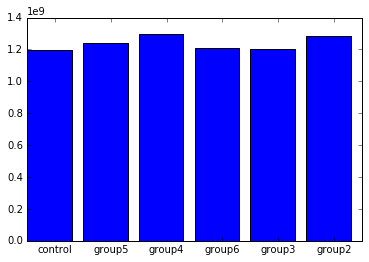

In [39]:
labels = [x for x, y in aggr_rasterize.items()]
counts = [sum(y) for x, y in aggr_rasterize.items()]
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

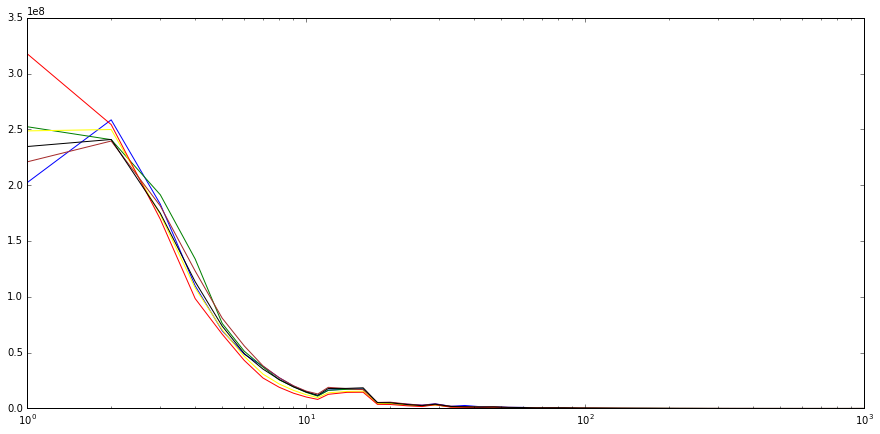

In [40]:
aggr_rasterize["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_rasterize["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_rasterize["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_rasterize["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_rasterize["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_rasterize["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")